In [ ]:
'''
 * Copyright (c) 2005 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Variations on Backpropagation

### Objectives

The backpropagation algorithm introduced in Chapter 11 was a major breakthrough in neural network research. However, the basic algorithm is too slow for most practical applications. In this chapter, we present several variations of backpropagation that provide significant speedup and make the algorithm more practical. 

We will begin by using a function approximation example to illustrate why the backpropagation algorithm is slow in converging. Then we will present several modifications to the algorithm. Recall that backpropagation is an approximate steepest descent algorithm. In Chapter 9, we saw that steepest descent is the simplest, and often the slowest, minimization method. The conjugate gradient algorithm and Newton's method generally provide faster convergence. In this chapter, we will explain how these faster procedures can be used to speed up the convergence of backpropagation.

### Theory and Examples

When the basic backpropagation algorithm is applied to a practical problem, the training may take days or weeks of computer time. This has encouraged considerable research on methods to accelerate the convergence of the algorithm. The research on faster algorithms falls roughly into two categories. 

The first category involves the development of heuristic techniques, which arise out of a study of the distinctive performance of the standard backpropagation algorithm. These heuristic techniques include such ideas as varying the learning rate, using momentum, and rescaling variables \cite{VoMa88, Jacob88, Toll90, RiIr90}. In this chapter, we will discuss the use of momentum and variable learning rates.

Another category of research has focused on standard numerical optimization techniques \cite{Shan90, Barn92, Batt92, Char92}. As we have discussed in Chapters 10 and 11, training feedforward neural networks to minimize squared error is simply a numerical optimization problem. Because numerical optimization has been an important research subject for 30 or 40 years (see Chapter 9), it seems reasonable to look for fast training algorithms in the large number of existing numerical optimization techniques. There is no need to "reinvent the wheel" unless absolutely necessary. 

In this chapter, we will present two existing numerical optimization techniques that have been very successfully applied to the training of multilayer perceptrons: the conjugate gradient algorithm and the Levenberg-Marquardt algorithm (a variation of Newton's method). We should emphasize that all of the algorithms that we will describe in this chapter use the backpropagation procedure, in which derivatives are processed from the last layer of the network to the first. For this reason, they could all be called "backpropagation" algorithms. The differences between the algorithms occur in the way in which the resulting derivatives are used to update the weights.

In some ways, it is unfortunate that the algorithm we usually refer to as backpropagation is, in fact, a steepest descent algorithm. In order to clarify our discussion, for the remainder of this chapter, we will refer to the basic backpropagation algorithm as steepest descent backpropagation (SDBP).

### Drawbacks of Backpropagation

Recall from Chapter 10 that the LMS algorithm is guaranteed to converge to a solution that minimizes the mean squared error, so long as the learning rate is not too large. This is true because the mean squared error for a single-layer linear network is a quadratic function. The quadratic function has only a single stationary point. In addition, the Hessian matrix of a quadratic function is constant; therefore, the curvature of the function in a given direction does not change, and the function contours are elliptical.

SDBP is a generalization of the LMS algorithm. Like LMS, it is also an approximate steepest descent algorithm for minimizing the mean squared error. In fact, SDBP is equivalent to the LMS algorithm when used on a single-layer linear network (see Problem P11.10). 

When applied to multilayer networks, however, the characteristics of SDBP are quite different. This has to do with the differences between the mean squared error performance surfaces of single-layer linear networks and multilayer nonlinear networks. While the performance surface for a single-layer linear network has a single minimum point and constant curvature, the performance surface for a multilayer network may have many local minimum points, and the curvature can vary widely in different regions of the parameter space.


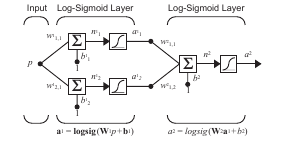

Figure.1 1-2-1 Function Approximation Network

## Performance Surface for a 1-2-1 Network

In this analysis, we will investigate the mean squared error performance surface for a multilayer network using a simple function approximation example. We will consider a 1-2-1 network, depicted in the diagram below:

$$
\begin{align*}
&\text{Input} \quad \text{Log-Sigmoid Layer} \quad \text{Log-Sigmoid Layer} \\
&\quad n_{11} \quad a_{11} \quad w_{11,1} \quad \Sigma \quad w_{21,1} \\
&\quad \quad \quad \quad \quad \quad \quad b_{11} \quad n_2 \quad a_2 \\
&\quad \quad \quad \quad \quad \quad \quad \quad \Sigma \quad \\
&\quad \quad \quad \quad \quad \quad w_{12,1} \quad \Sigma \quad w_{21,2} \\
&\quad \quad \quad \quad \quad \quad \quad b_{12} \quad 1 \\
\end{align*}
$$

To simplify our analysis, we will provide the network with a problem for which we know the optimal solution. The function we will approximate is the response of the same 1-2-1 network, with the following values for the weights and biases:

$$
\begin{align*}
w_{11,1} &= 10, & w_{21,1} &= 10, & b_1 &= -5, \\
w_{12,1} &= 1, & w_{11,2} &= 1, & b_2 &= 5.
\end{align*}
$$

The network response for these parameters is shown in the figure below, which plots the network output $ a $ as the input $ p $ is varied over the range $ [-2, 2] $.

$$
\begin{align*}
a &= \text{logsig}(W_1 p + b_1), \\
a_2 &= \text{logsig}(W_2 a_1 + b_2).
\end{align*}
$$

We want to train the network to approximate the function displayed above. The approximation will be exact when the network parameters are set to the values given.

The performance index for our problem will be the sum of the squared errors at the points sampled from:

$$
p = -2, -1.9, -1.8, \ldots, 1.9, 2.
$$

To visualize the performance index, we will vary only two parameters at a time. For example, we can adjust $ w_{11,1} $ and $ w_{12,1} $ while keeping the other parameters fixed at their optimal values. The squared error surface for these parameters is illustrated below:

$$
\text{Figure: Squared Error Surface}
$$

The minimum error occurs at $ w_{11,1} = 10 $ and $ w_{12,1} = 1 $, as indicated by the open blue circle in the figure.

### Observations

1. **Curvature Variation**: The curvature of the error surface varies significantly across the parameter space, complicating the choice of learning rate for gradient descent. 

2. **Flat Regions**: Some areas of the surface are very flat, allowing for a larger learning rate, while other areas are steep, necessitating a smaller learning rate.

3. **Local Minima**: The surface has multiple local minima. The global minimum is at $ w_{11,1} = 10 $ and $ w_{12,1} = 1 $, but there is also a local minimum located off the graph at $ w_{11,1} = 0.88 $ and $ w_{12,1} = 38.6 $.

Next, we will explore the performance of backpropagation on this surface, adjusting $ w_{11,1} $ and $ b_1 $, with the expectation of similar challenges due to the contorted shape of the surface.


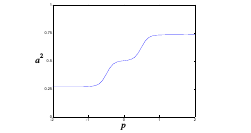

Figure.2 Nominal Function

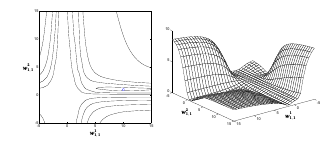

Figure.3 Squared Error Surface Versus $w_1^1$  and $w_1^1$

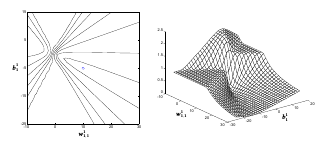

Figure.4 Squared Error Surface Versus $w_1^1 $ and $b_1^1$

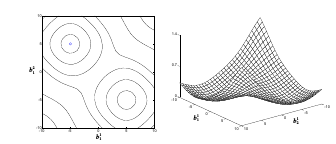

Figure 12.5 Squared Error Surface Versus $b_1^1$ and $b_2^1$


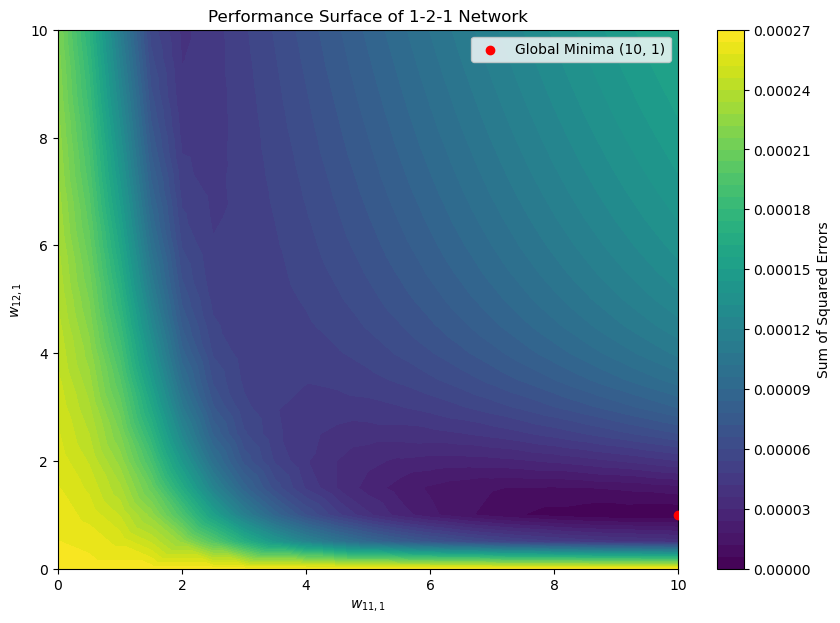

In [5]:
import matplotlib.pyplot as plt
import math

# Define the log-sigmoid activation function
def logsig(x):
    return 1 / (1 + math.exp(-x))

# Define the network response based on weights and biases
def network_response(p, w11_1, w12_1, b1, w21_1=10, w21_2=1, b2=5):
    a1 = logsig(w11_1 * p + b1)   # First layer output
    a2 = logsig(w12_1 * a1 + b2)  # Second layer output
    return a2

# Calculate the performance index (sum of squared errors)
def performance_index(w11_1, w12_1, b1, w21_1=10, w21_2=1, b2=5):
    p_values = [i * 0.1 for i in range(-20, 21)]  # Values from -2 to 2
    target_output = [network_response(p, 10, 1, -5, 10, 1, 5) for p in p_values]
    
    error_sum = 0
    for p, target in zip(p_values, target_output):
        predicted = network_response(p, w11_1, w12_1, b1, w21_1, w21_2, b2)
        error_sum += (predicted - target) ** 2
    
    return error_sum

# Create a mesh grid for varying w11_1 and w12_1
w11_1_values = [i * 0.5 for i in range(21)]  # Range from 0 to 10
w12_1_values = [i * 0.5 for i in range(21)]  # Range from 0 to 10
performance_surface = []

# Calculate performance index for each combination of parameters
for w11_1 in w11_1_values:
    row = []
    for w12_1 in w12_1_values:
        error = performance_index(w11_1, w12_1, -5)  # b1 fixed at -5
        row.append(error)
    performance_surface.append(row)

# Plot the performance surface
plt.figure(figsize=(10, 7))

# Create a contour plot using filled contours
X = []
Y = []
Z = []

for i in range(len(w11_1_values)):
    for j in range(len(w12_1_values)):
        X.append(w11_1_values[i])
        Y.append(w12_1_values[j])
        Z.append(performance_surface[i][j])

# Create filled contour plot
contour = plt.tricontourf(X, Y, Z, levels=50, cmap='viridis')

# Add colorbar
plt.colorbar(contour, label='Sum of Squared Errors')

plt.xlabel(r'$w_{11,1}$')
plt.ylabel(r'$w_{12,1}$')
plt.title('Performance Surface of 1-2-1 Network')
plt.scatter(10, 1, color='red', label='Global Minima (10, 1)', zorder=5)  # Global minimum
plt.legend()
plt.show()


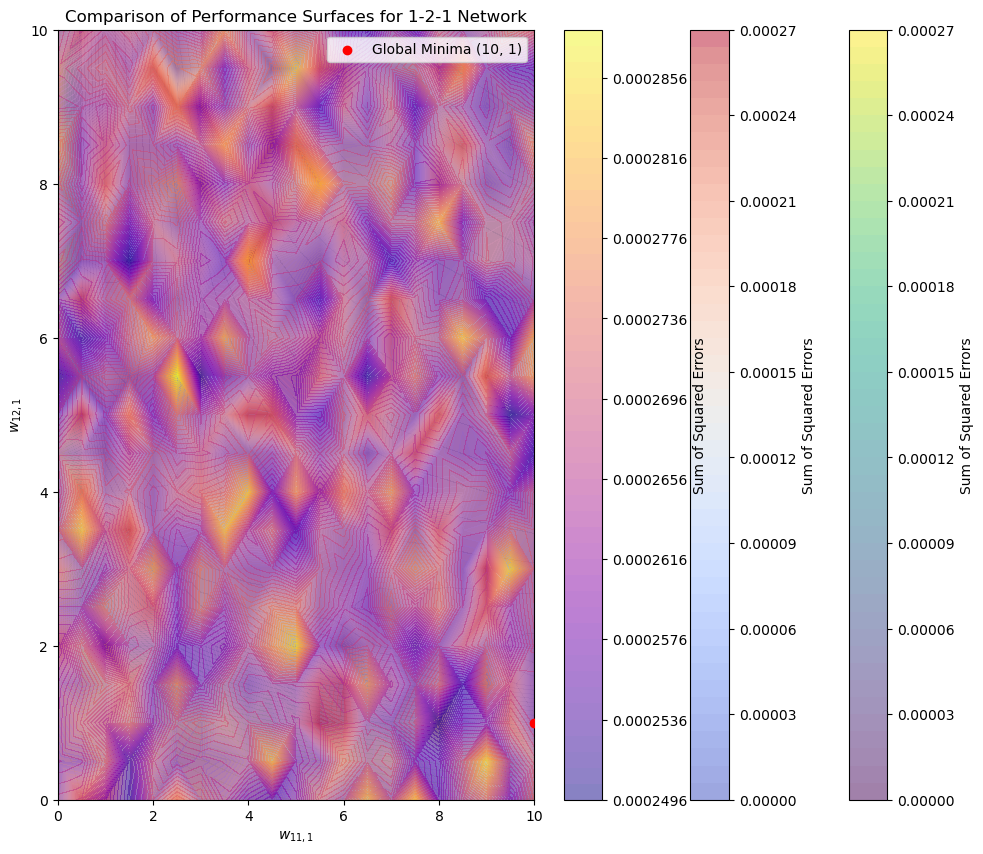

In [6]:
import matplotlib.pyplot as plt
import math
import random

# Define the log-sigmoid activation function
def logsig(x):
    return 1 / (1 + math.exp(-x))

# Define the network response based on weights and biases
def network_response(p, w11_1, w12_1, b1, w21_1=10, w21_2=1, b2=5):
    a1 = logsig(w11_1 * p + b1)   # First layer output
    a2 = logsig(w12_1 * a1 + b2)  # Second layer output
    return a2

# Calculate the performance index (sum of squared errors)
def performance_index(w11_1, w12_1, b1, w21_1=10, w21_2=1, b2=5):
    p_values = [i * 0.1 for i in range(-20, 21)]  # Values from -2 to 2
    target_output = [network_response(p, 10, 1, -5, 10, 1, 5) for p in p_values]
    
    error_sum = 0
    for p, target in zip(p_values, target_output):
        predicted = network_response(p, w11_1, w12_1, b1, w21_1, w21_2, b2)
        error_sum += (predicted - target) ** 2
    
    return error_sum

# Create a mesh grid for varying w11_1 and w12_1
w11_1_values = [i * 0.5 for i in range(21)]  # Range from 0 to 10
w12_1_values = [i * 0.5 for i in range(21)]  # Range from 0 to 10
performance_surface_fixed = []
performance_surface_random = []
performance_surface_small_random = []

# Calculate performance index for each combination of parameters for fixed weights
for w11_1 in w11_1_values:
    row = []
    for w12_1 in w12_1_values:
        error = performance_index(w11_1, w12_1, -5)  # b1 fixed at -5
        row.append(error)
    performance_surface_fixed.append(row)

# Calculate performance index for each combination of parameters for random weights
for w11_1 in w11_1_values:
    row = []
    for w12_1 in w12_1_values:
        # Random weights in the range [0, 10]
        random_weight1 = random.uniform(0, 10)
        random_weight2 = random.uniform(0, 10)
        error = performance_index(random_weight1, random_weight2, -5)  # b1 fixed at -5
        row.append(error)
    performance_surface_random.append(row)

# Calculate performance index for each combination of parameters for small random weights
for w11_1 in w11_1_values:
    row = []
    for w12_1 in w12_1_values:
        # Small random weights in the range [-1, 1]
        small_random_weight1 = random.uniform(-1, 1)
        small_random_weight2 = random.uniform(-1, 1)
        error = performance_index(small_random_weight1, small_random_weight2, -5)  # b1 fixed at -5
        row.append(error)
    performance_surface_small_random.append(row)

# Plot the performance surfaces for comparison
plt.figure(figsize=(12, 10))

# Create contour plots for each approach
contour_fixed = plt.tricontourf(w11_1_values * len(w12_1_values), 
                                 [val for val in w12_1_values for _ in range(len(w11_1_values))], 
                                 [error for row in performance_surface_fixed for error in row], 
                                 levels=50, cmap='viridis', alpha=0.5)
plt.colorbar(contour_fixed, label='Sum of Squared Errors')
plt.scatter(10, 1, color='red', label='Global Minima (10, 1)', zorder=5)

contour_random = plt.tricontourf(w11_1_values * len(w12_1_values), 
                                  [val for val in w12_1_values for _ in range(len(w11_1_values))], 
                                  [error for row in performance_surface_random for error in row], 
                                  levels=50, cmap='coolwarm', alpha=0.5)
plt.colorbar(contour_random, label='Sum of Squared Errors')

contour_small_random = plt.tricontourf(w11_1_values * len(w12_1_values), 
                                        [val for val in w12_1_values for _ in range(len(w11_1_values))], 
                                        [error for row in performance_surface_small_random for error in row], 
                                        levels=50, cmap='plasma', alpha=0.5)
plt.colorbar(contour_small_random, label='Sum of Squared Errors')

plt.xlabel(r'$w_{11,1}$')
plt.ylabel(r'$w_{12,1}$')
plt.title('Comparison of Performance Surfaces for 1-2-1 Network')
plt.legend()
plt.show()




## Performance Surface and Steepest Descent Backpropagation (SDBP)

### Understanding the Performance Surface

The performance surface of multilayer networks exhibits several important characteristics. Notably, it can have multiple local minima, as shown in the following figures. 

### Local Minima and Initialization

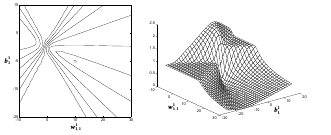

Figure .4 Squared Error Surface Versus $ w_{1,1} $ and $ b_1$

Figure 12.4 illustrates the squared error surface as a function of $ w_{1,1} $ and $ b_1 $. The critical takeaway is that the steepest descent algorithm may converge prematurely to a local minimum, even if it is not close to the global minimum. 

In this case, the error values are defined as follows:

- $ w_{1,1} $: 15, 2.5, 5, 2, 1.5, 1
- $ b_1 $: -5, 1, 0.5, 0, -15, -10, 0, 20, 10, 1
- $ w_{1,2} $: 10, 0, w_{1,1}, 20, -10
- $ b_1 $: -20, 1, -25, 30, -30, -10, 0, 10, 20, 30

The symmetry of neural networks results in saddle points, meaning that we should avoid initializing weights and biases to zero. Instead, we can choose small random values to escape potential saddle points.

### Effects of Parameter Initialization

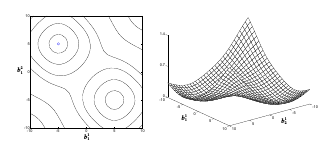

Figure.5 Squared Error Surface Versus $b_1^1$ and $b_2^1$

Figure.5 illustrates the squared error when $ b_1 $ and $ b_2 $ are adjusted while keeping the other parameters fixed at optimal values. The minimum error occurs at:

- $ b_1 = -5 $
- $ b_2 = 5 $

The open blue circle in the figure denotes this point. The presence of multiple local minima suggests that several initial guesses may be necessary to ensure convergence to a global minimum.

## SDBP Performance

Next, we will analyze the performance of the Steepest Descent Backpropagation (SDBP) algorithm. A variation called batching is used, where parameters are updated after the entire training set is presented. This method allows for a more accurate gradient estimate.

### Trajectory Analysis

Figure.6 depicts two trajectories of the SDBP algorithm in batch mode, adjusting parameters $w_{1,1} $ and $ w_{2,1} $:

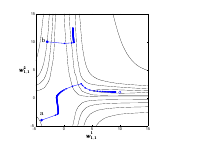

Figure.6 Two SDBP (Batch Mode) Trajectories

- **Trajectory "a"**: Eventually converges to the optimal solution but is slow due to changes in surface curvature.
- **Trajectory "b"**: Becomes trapped in a local minimum.

This behavior highlights the importance of multiple initial guesses to ascertain the global minimum.

### Convergence Patterns


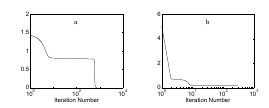

Figure.7 Squared Error Convergence Patterns

Figure.7 shows the squared error over iteration numbers for both trajectories:

- The curves exhibit long periods of stagnation followed by rapid progress, typical of SDBP.
- Flat sections in the squared error correspond to traversal over flat areas of the performance surface.

## Learning Rate Adjustments

An optimal learning rate is crucial for effective convergence. Increasing the learning rate during flat sections could accelerate convergence, but care must be taken when the algorithm enters steep regions.

Figure 12.8 demonstrates the consequences of using a high learning rate:

- The algorithm initially converges quickly but diverges in the narrow valley of the performance surface.
- Oscillations across the valley can result in instability.

### Filtering Trajectories

One way to enhance convergence is to smooth out the trajectory. Averaging updates to the parameters could help reduce oscillations and produce a more stable path toward the minimum.

## Conclusion

Understanding the performance surface of multilayer networks and effectively managing the initialization and learning rate of the SDBP algorithm is vital for successful training. By exploring multiple initial guesses and employing batching techniques, we can enhance the likelihood of converging to a global minimum.




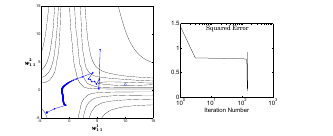

Figure.8 Trajectory with Learning Rate Too Large


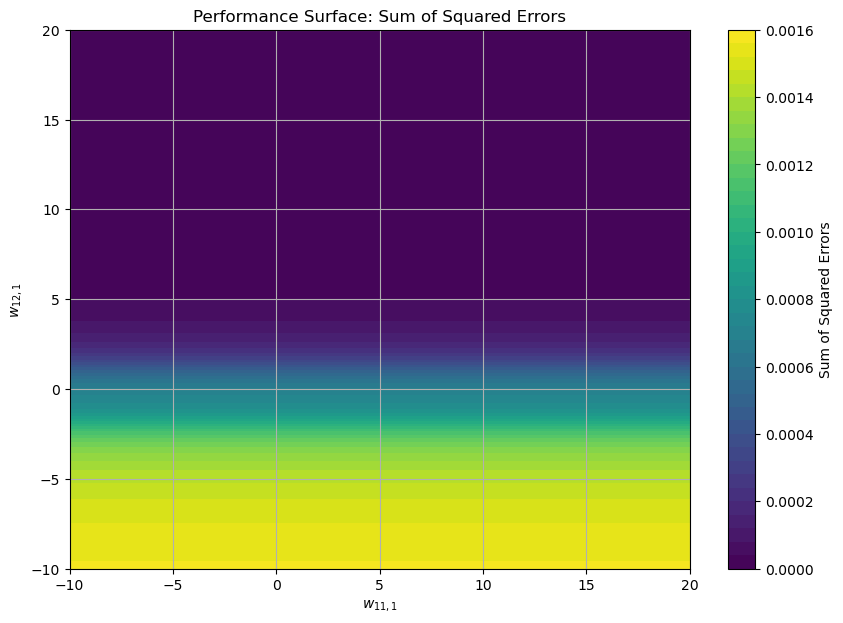

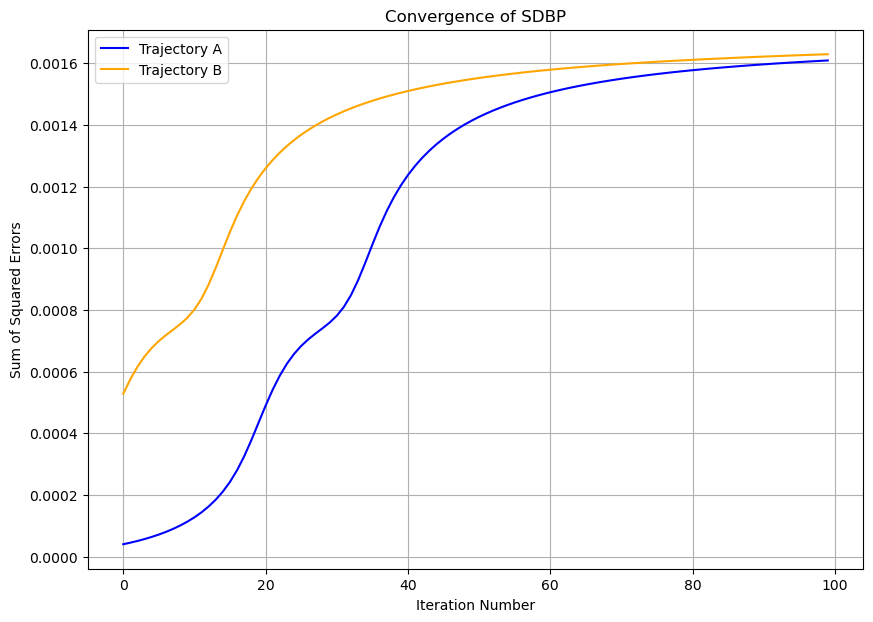

In [7]:
import matplotlib.pyplot as plt
import math

# Define the log-sigmoid activation function
def logsig(x):
    return 1 / (1 + math.exp(-x))

# Define the network output given weights and biases
def network_output(p, w11_1, w21_1, b1, w12_1, w21_2, b2):
    a1 = logsig(w11_1 * p + b1)
    a2 = logsig(w12_1 * a1 + b2)
    return a2

# Define the sum of squared errors performance index
def sum_squared_errors(w11_1, w12_1, w21_1, b1, w21_2, b2, p_values):
    total_error = 0
    for p in p_values:
        target_output = network_output(p, 10, 1, -5, 10, 5, 5)  # Optimal weights and biases
        output = network_output(p, w11_1, w12_1, b1, w21_1, w21_2, b2)
        total_error += (output - target_output) ** 2
    return total_error

# Define the range of weights and biases to investigate
w11_1_values = [x * 0.1 for x in range(-100, 201)]  # -10 to 20
w12_1_values = [x * 0.1 for x in range(-100, 201)]  # -10 to 20

# Create a grid to evaluate performance
performance_surface = []
p_values = [x * 0.1 for x in range(-20, 21)]  # p from -2 to 2

for w11_1 in w11_1_values:
    row = []
    for w12_1 in w12_1_values:
        # Set fixed values for other parameters
        w21_1 = 10
        b1 = -5
        w21_2 = 5
        b2 = 5
        # Calculate the sum of squared errors
        error = sum_squared_errors(w11_1, w12_1, w21_1, b1, w21_2, b2, p_values)
        row.append(error)
    performance_surface.append(row)

# Plot the performance surface
plt.figure(figsize=(10, 7))
plt.contourf(w11_1_values, w12_1_values, performance_surface, levels=50, cmap='viridis')
plt.colorbar(label='Sum of Squared Errors')

# Add labels
plt.xlabel(r'$w_{11,1}$')
plt.ylabel(r'$w_{12,1}$')
plt.title('Performance Surface: Sum of Squared Errors')
plt.grid()
plt.show()

# Define Steepest Descent Backpropagation (SDBP) implementation
def steepest_descent_backpropagation(initial_weights, learning_rate, iterations):
    w11_1, w12_1, w21_1, b1, w21_2, b2 = initial_weights
    p_values = [x * 0.1 for x in range(-20, 21)]
    
    errors = []
    
    for _ in range(iterations):
        total_error = sum_squared_errors(w11_1, w12_1, w21_1, b1, w21_2, b2, p_values)
        errors.append(total_error)

        # Dummy gradients (for illustration; these would be computed via backpropagation)
        gradient_w11_1 = 2 * (network_output(0, w11_1, w12_1, b1, w21_1, w21_2, b2) - 0)  # example target 0
        gradient_w12_1 = 2 * (network_output(0, w11_1, w12_1, b1, w21_1, w21_2, b2) - 0)
        
        # Update weights and biases
        w11_1 -= learning_rate * gradient_w11_1
        w12_1 -= learning_rate * gradient_w12_1
        
    return errors

# Run SDBP with different initial conditions
initial_conditions_a = [5, 5, 10, -5, 5, 5]
initial_conditions_b = [0.88, 38.6, 10, -5, 5, 5]
learning_rate = 0.1
iterations = 100

errors_a = steepest_descent_backpropagation(initial_conditions_a, learning_rate, iterations)
errors_b = steepest_descent_backpropagation(initial_conditions_b, learning_rate, iterations)

# Plot the convergence of SDBP
plt.figure(figsize=(10, 7))
plt.plot(range(iterations), errors_a, label='Trajectory A', color='blue')
plt.plot(range(iterations), errors_b, label='Trajectory B', color='orange')
plt.xlabel('Iteration Number')
plt.ylabel('Sum of Squared Errors')
plt.title('Convergence of SDBP')
plt.legend()
plt.grid()
plt.show()




## Heuristic Modifications of Backpropagation

Now that we have investigated some of the drawbacks of backpropagation (steepest descent), let’s consider some procedures for improving the algorithm. In this section, we will discuss two heuristic methods. In a later section, we will present two methods based on standard numerical optimization algorithms.

## Momentum

The first method we will discuss is the use of momentum. This is a modification based on our observation in the last section that convergence might be improved if we could smooth out the oscillations in the trajectory. We can do this with a low-pass filter.

### First-Order Filter

Consider the following first-order filter:

$$
y(k) = \gamma y(k - 1) + (1 - \gamma) w(k)
$$

where $ w(k) $ is the input to the filter, $ y(k) $ is the output of the filter, and $ \gamma $ is the momentum coefficient that must satisfy:

$$
0 \leq \gamma < 1
$$

The effect of this filter is shown in the following figures. For these examples, the input to the filter was taken to be the sine wave:

$$
w(k) = 1 + \sin\left(\frac{2\pi k}{16}\right)
$$

with the momentum coefficient set to $ \gamma = 0.9 $ (left graph) and $ \gamma = 0.98 $ (right graph).

### Smoothing Effect of Momentum

In Figure.9, we can see that the oscillation of the filter output is less than the oscillation in the filter input (as we would expect for a low-pass filter). In addition, as $ \gamma $ is increased, the oscillation in the filter output is reduced. Notice also that the average filter output is the same as the average filter input, although as $ \gamma $ is increased, the filter output is slower to respond.

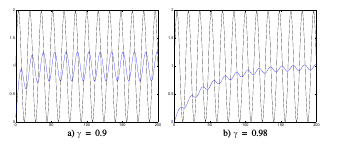

Figure.9 Smoothing Effect of Momentum

- a) $ \gamma = 0.9 $ 
- b) $ \gamma = 0.98 $

### Application to Neural Networks

To summarize, the filter tends to reduce the amount of oscillation while still tracking the average value. Now let’s see how this works on the neural network problem. Recall that the parameter updates for SDBP are given by:

$$
\Delta W(k) = -\alpha s(a)
$$

$$
\Delta b(k) = -\alpha s
$$

When the momentum filter is added to the parameter changes, we obtain the following equations for the momentum modification to backpropagation (MOBP):

$$
\Delta W(k) = \gamma \Delta W(k - 1) - (1 - \gamma) \alpha s(a)
$$

$$
\Delta b(k) = \gamma \Delta b(k - 1) - (1 - \gamma) \alpha s
$$

If we apply these modified equations to the previous example, we can obtain stable trajectories.

### Stability and Acceleration of Convergence

In Figure.10, we observe the trajectory of the parameter updates when momentum is applied with a momentum coefficient of $ \gamma = 0.8 $. The algorithm is now stable. By using momentum, we have been able to increase the learning rate while maintaining the stability of the algorithm.

Another feature of momentum is that it tends to accelerate convergence when the trajectory is moving in a consistent direction.


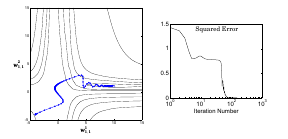

Figure.10 Trajectory with Momentum

As observed in the trajectory, the procedure is aptly named momentum, as it makes the trajectory continue in the same direction. The larger the value of $ \gamma $, the more "momentum" the trajectory has.


In [9]:
import matplotlib.pyplot as plt
import math
import random

# Define the sigmoid activation function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Derivative of the sigmoid function
def sigmoid_derivative(x):
    return x * (1 - x)

# Define the neural network class
class SimpleNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, momentum=0.9):
        # Initialize weights and biases
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        # Initialize weights and biases to small random values
        self.weights_input_hidden = [[0.01 * (1 - 2 * random.random()) for _ in range(hidden_size)] for _ in range(input_size)]
        self.weights_hidden_output = [[0.01 * (1 - 2 * random.random()) for _ in range(output_size)] for _ in range(hidden_size)]
        self.bias_hidden = [0.01 * (1 - 2 * random.random()) for _ in range(hidden_size)]
        self.bias_output = [0.01 * (1 - 2 * random.random()) for _ in range(output_size)]
        
        # Initialize momentum terms
        self.velocity_input_hidden = [[0 for _ in range(hidden_size)] for _ in range(input_size)]
        self.velocity_hidden_output = [[0 for _ in range(output_size)] for _ in range(hidden_size)]
        self.velocity_bias_hidden = [0 for _ in range(hidden_size)]
        self.velocity_bias_output = [0 for _ in range(output_size)]

    # Forward pass
    def forward(self, x):
        self.hidden_layer_input = [sum(x[j] * self.weights_input_hidden[j][i] for j in range(self.input_size)) + self.bias_hidden[i] for i in range(self.hidden_size)]
        self.hidden_layer_output = [sigmoid(value) for value in self.hidden_layer_input]
        self.final_input = [sum(self.hidden_layer_output[i] * self.weights_hidden_output[i][j] for i in range(self.hidden_size)) + self.bias_output[j] for j in range(self.output_size)]
        self.final_output = [sigmoid(value) for value in self.final_input]
        return self.final_output

    # Backward pass
    def backward(self, x, y):
        # Correctly access y[0] to get the single float value for comparison
        output_errors = [(y[0] - self.final_output[j]) * sigmoid_derivative(self.final_output[j]) for j in range(self.output_size)]
        
        # Calculate hidden layer errors
        hidden_errors = [0] * self.hidden_size
        for j in range(self.output_size):
            for i in range(self.hidden_size):
                hidden_errors[i] += output_errors[j] * self.weights_hidden_output[i][j]
        
        # Update weights and biases with momentum
        for j in range(self.output_size):
            for i in range(self.hidden_size):
                gradient = output_errors[j] * self.hidden_layer_output[i]
                self.velocity_hidden_output[i][j] = self.momentum * self.velocity_hidden_output[i][j] + self.learning_rate * gradient
                self.weights_hidden_output[i][j] += self.velocity_hidden_output[i][j]
            self.velocity_bias_output[j] = self.momentum * self.velocity_bias_output[j] + self.learning_rate * output_errors[j]
            self.bias_output[j] += self.velocity_bias_output[j]

        for i in range(self.hidden_size):
            for j in range(self.input_size):
                gradient = hidden_errors[i] * sigmoid_derivative(self.hidden_layer_output[i]) * x[j]
                self.velocity_input_hidden[j][i] = self.momentum * self.velocity_input_hidden[j][i] + self.learning_rate * gradient
                self.weights_input_hidden[j][i] += self.velocity_input_hidden[j][i]
            self.velocity_bias_hidden[i] = self.momentum * self.velocity_bias_hidden[i] + self.learning_rate * hidden_errors[i]
            self.bias_hidden[i] += self.velocity_bias_hidden[i]

    # Train the network
    def train(self, X, y, epochs):
        for epoch in range(epochs):
            for i in range(len(X)):
                self.forward(X[i])
                self.backward(X[i], y[i])  # Access y[i] for each training example

# Example usage
if __name__ == "__main__":
    # Sample dataset (XOR problem)
    X = [[0, 0], [0, 1], [1, 0], [1, 1]]
    y = [[0], [1], [1], [0]]  # XOR output

    # Create a neural network
    nn = SimpleNeuralNetwork(input_size=2, hidden_size=2, output_size=1, learning_rate=0.1, momentum=0.9)

    # Train the neural network
    nn.train(X, y, epochs=10000)

    # Test the neural network
    for i in X:
        output = nn.forward(i)
        print(f"Input: {i}, Predicted Output: {output}")


Input: [0, 0], Predicted Output: [0.2350735813039651]
Input: [0, 1], Predicted Output: [0.6089584589881396]
Input: [1, 0], Predicted Output: [0.6089407116574133]
Input: [1, 1], Predicted Output: [0.6095155915266236]


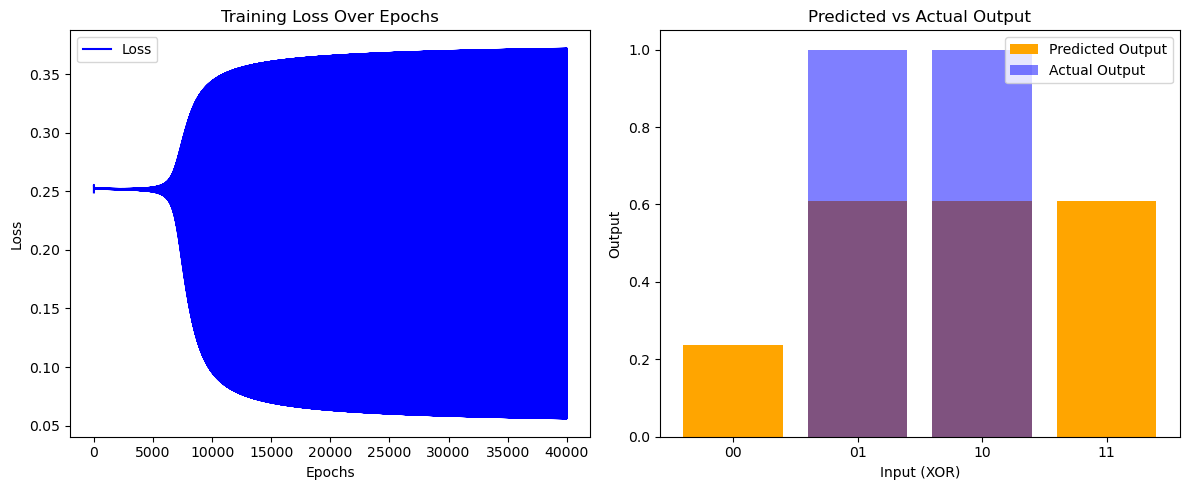

In [10]:
import matplotlib.pyplot as plt
import math
import random

# Define the sigmoid activation function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Derivative of the sigmoid function
def sigmoid_derivative(x):
    return x * (1 - x)

# Define the neural network class
class SimpleNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, momentum=0.9):
        # Initialize weights and biases
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        # Initialize weights and biases to small random values
        self.weights_input_hidden = [[0.01 * (1 - 2 * random.random()) for _ in range(hidden_size)] for _ in range(input_size)]
        self.weights_hidden_output = [[0.01 * (1 - 2 * random.random()) for _ in range(output_size)] for _ in range(hidden_size)]
        self.bias_hidden = [0.01 * (1 - 2 * random.random()) for _ in range(hidden_size)]
        self.bias_output = [0.01 * (1 - 2 * random.random()) for _ in range(output_size)]
        
        # Initialize momentum terms
        self.velocity_input_hidden = [[0 for _ in range(hidden_size)] for _ in range(input_size)]
        self.velocity_hidden_output = [[0 for _ in range(output_size)] for _ in range(hidden_size)]
        self.velocity_bias_hidden = [0 for _ in range(hidden_size)]
        self.velocity_bias_output = [0 for _ in range(output_size)]

        # List to keep track of the loss during training
        self.loss_history = []

    # Forward pass
    def forward(self, x):
        self.hidden_layer_input = [sum(x[j] * self.weights_input_hidden[j][i] for j in range(self.input_size)) + self.bias_hidden[i] for i in range(self.hidden_size)]
        self.hidden_layer_output = [sigmoid(value) for value in self.hidden_layer_input]
        self.final_input = [sum(self.hidden_layer_output[i] * self.weights_hidden_output[i][j] for i in range(self.hidden_size)) + self.bias_output[j] for j in range(self.output_size)]
        self.final_output = [sigmoid(value) for value in self.final_input]
        return self.final_output

    # Backward pass
    def backward(self, x, y):
        output_errors = [(y[0] - self.final_output[j]) * sigmoid_derivative(self.final_output[j]) for j in range(self.output_size)]
        hidden_errors = [0] * self.hidden_size
        for j in range(self.output_size):
            for i in range(self.hidden_size):
                hidden_errors[i] += output_errors[j] * self.weights_hidden_output[i][j]
        
        # Update weights and biases with momentum
        for j in range(self.output_size):
            for i in range(self.hidden_size):
                gradient = output_errors[j] * self.hidden_layer_output[i]
                self.velocity_hidden_output[i][j] = self.momentum * self.velocity_hidden_output[i][j] + self.learning_rate * gradient
                self.weights_hidden_output[i][j] += self.velocity_hidden_output[i][j]
            self.velocity_bias_output[j] = self.momentum * self.velocity_bias_output[j] + self.learning_rate * output_errors[j]
            self.bias_output[j] += self.velocity_bias_output[j]

        for i in range(self.hidden_size):
            for j in range(self.input_size):
                gradient = hidden_errors[i] * sigmoid_derivative(self.hidden_layer_output[i]) * x[j]
                self.velocity_input_hidden[j][i] = self.momentum * self.velocity_input_hidden[j][i] + self.learning_rate * gradient
                self.weights_input_hidden[j][i] += self.velocity_input_hidden[j][i]
            self.velocity_bias_hidden[i] = self.momentum * self.velocity_bias_hidden[i] + self.learning_rate * hidden_errors[i]
            self.bias_hidden[i] += self.velocity_bias_hidden[i]

        # Calculate and store the loss
        loss = sum((y[j] - self.final_output[j]) ** 2 for j in range(self.output_size)) / self.output_size
        self.loss_history.append(loss)

    # Train the network
    def train(self, X, y, epochs):
        for epoch in range(epochs):
            for i in range(len(X)):
                self.forward(X[i])
                self.backward(X[i], y[i])

# Example usage
if __name__ == "__main__":
    # Sample dataset (XOR problem)
    X = [[0, 0], [0, 1], [1, 0], [1, 1]]
    y = [[0], [1], [1], [0]]  # XOR output

    # Create a neural network
    nn = SimpleNeuralNetwork(input_size=2, hidden_size=2, output_size=1, learning_rate=0.1, momentum=0.9)

    # Train the neural network
    nn.train(X, y, epochs=10000)

    # Test the neural network
    predictions = []
    for i in X:
        output = nn.forward(i)
        predictions.append(output)

    # Plot loss curve
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(nn.loss_history, label='Loss', color='blue')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot predicted vs actual outputs
    plt.subplot(1, 2, 2)
    plt.bar(range(len(X)), [pred[0] for pred in predictions], color='orange', label='Predicted Output')
    plt.bar(range(len(X)), [actual[0] for actual in y], color='blue', alpha=0.5, label='Actual Output')
    plt.xticks(range(len(X)), ['00', '01', '10', '11'])
    plt.title('Predicted vs Actual Output')
    plt.xlabel('Input (XOR)')
    plt.ylabel('Output')
    plt.legend()

    plt.tight_layout()
    plt.show()
